# Prediction Model using TuriCreate in Julia

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-Up" data-toc-modified-id="Set-Up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set Up</a></span></li><li><span><a href="#Fetch-Data-(SFrame)-from-Uber-CSV" data-toc-modified-id="Fetch-Data-(SFrame)-from-Uber-CSV-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fetch Data (SFrame) from Uber CSV</a></span></li><li><span><a href="#Split-Data" data-toc-modified-id="Split-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Split Data</a></span></li><li><span><a href="#Train-the-Model" data-toc-modified-id="Train-the-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train the Model</a></span></li><li><span><a href="#Evaluate-the-Model" data-toc-modified-id="Evaluate-the-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Evaluate the Model</a></span></li><li><span><a href="#Save-/-Export-the-Model" data-toc-modified-id="Save-/-Export-the-Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Save / Export the Model</a></span></li><li><span><a href="#Make-predictions" data-toc-modified-id="Make-predictions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Make predictions</a></span><ul class="toc-item"><li><span><a href="#Explore-SFrame" data-toc-modified-id="Explore-SFrame-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Explore SFrame</a></span></li></ul></li></ul></div>

## Set Up

In [1]:
## uncomment for the first run
# import Pkg
# Pkg.add("PyCall")
# Pkg.add("Conda")
# ENV["PYTHON"] = "/opt/anaconda3/envs/turi/bin/python"
# /opt/anaconda3/envs/turi/lib/python3.6/site-packages/
# Pkg.build("PyCall")


symbol_to_predict = "AAPL" ## Comment OUT when running as include Julia file

println("symbol_to_predict ", symbol_to_predict )

symbol_to_predict AAPL


In [2]:
## Read feature names (columns) from the text file 
features_to_analyze = readlines("../DATA/features_to_analyze.txt") # returns Array{String,1}

329-element Array{String,1}:
 "AAPL_Avg005"
 "AAPL_Avg010"
 "AAPL_Avg030"
 "AAPL_Avg060"
 "AAPL_Avg090"
 "AAPL_Avg120"
 "AAPL_Avg180"
 "ARKK_Avg005"
 "ARKK_Avg010"
 "ARKK_Avg030"
 "ARKK_Avg060"
 "ARKK_Avg090"
 "ARKK_Avg120"
 ⋮
 "VIX_Avg030"
 "VIX_Avg060"
 "VIX_Avg090"
 "VIX_Avg120"
 "VIX_Avg180"
 "WMT_Avg005"
 "WMT_Avg010"
 "WMT_Avg030"
 "WMT_Avg060"
 "WMT_Avg090"
 "WMT_Avg120"
 "WMT_Avg180"

In [3]:
include("../Julia/functions.jl") 
include("../Julia/format_dates.jl")

data_path="../DATA/processed/uber_training.csv"
#column_to_predict = symbol_to_predict * "_Original"
column_to_predict = symbol_to_predict * "_Avg005"

"AAPL_Avg005"

In [4]:
## Remove column to predict from features
typeof(features_to_analyze)

filter!(e->e≠ column_to_predict , features_to_analyze)
println(features_to_analyze)

["AAPL_Avg010", "AAPL_Avg030", "AAPL_Avg060", "AAPL_Avg090", "AAPL_Avg120", "AAPL_Avg180", "ARKK_Avg005", "ARKK_Avg010", "ARKK_Avg030", "ARKK_Avg060", "ARKK_Avg090", "ARKK_Avg120", "ARKK_Avg180", "ARKW_Avg005", "ARKW_Avg010", "ARKW_Avg030", "ARKW_Avg060", "ARKW_Avg090", "ARKW_Avg120", "ARKW_Avg180", "BABA_Avg005", "BABA_Avg010", "BABA_Avg030", "BABA_Avg060", "BABA_Avg090", "BABA_Avg120", "BABA_Avg180", "BRK_B_Avg005", "BRK_B_Avg010", "BRK_B_Avg030", "BRK_B_Avg060", "BRK_B_Avg090", "BRK_B_Avg120", "BRK_B_Avg180", "BTC_USD_Avg005", "BTC_USD_Avg010", "BTC_USD_Avg030", "BTC_USD_Avg060", "BTC_USD_Avg090", "BTC_USD_Avg120", "BTC_USD_Avg180", "BYDDF_Avg005", "BYDDF_Avg010", "BYDDF_Avg030", "BYDDF_Avg060", "BYDDF_Avg090", "BYDDF_Avg120", "BYDDF_Avg180", "CRSP_Avg005", "CRSP_Avg010", "CRSP_Avg030", "CRSP_Avg060", "CRSP_Avg090", "CRSP_Avg120", "CRSP_Avg180", "CRUDE_OIL_Avg005", "CRUDE_OIL_Avg010", "CRUDE_OIL_Avg030", "CRUDE_OIL_Avg060", "CRUDE_OIL_Avg090", "CRUDE_OIL_Avg120", "CRUDE_OIL_Avg180",

## Fetch Data (SFrame) from Uber CSV

In [5]:
## Fetch Data (SFrame) from Uber CSV

using PyCall
tc = pyimport("turicreate")
data = tc.SFrame(data_path)
println()

Finished parsing file /Users/uki/REPOS/MarketIndicators.jl/src/DATA/processed/uber_training.csv
Parsing completed. Parsed 100 lines in 0.045513 secs.
------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,floa

## Split Data

In [6]:
# Make a train-test split
train_data, test_data = data.random_split(0.9)

println( "train_data size = ", size(train_data) )
println( "test_data size = ", size(test_data)  )

train_data size = (1377,)
test_data size = (160,)


## Train the Model

In [7]:
## Train the Model
model = tc.regression.create( 
    train_data, 
    target = column_to_predict, 
    features = features_to_analyze, 
    validation_set="auto", 
    verbose=true
)

Automatically generating validation set from 5% of the data.
Linear regression:
--------------------------------------------------------
Number of examples          : 1308
Number of features          : 328
Number of unpacked features : 328
Number of coefficients    : 329
Starting Newton Method
--------------------------------------------------------
+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+
| Iteration | Passes   | Elapsed Time | Training Max Error | Validation Max Error | Training Root-Mean-Square Error | Validation Root-Mean-Square Error |
+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+
| 1         | 2        | 1.052437     | 2.886780           | 0.928851             | 0.496834                        | 0.395793                          |
+-----------+----------+--------

PyObject Class                          : LinearRegression

Schema
------
Number of coefficients         : 329
Number of examples             : 1308
Number of feature columns      : 328
Number of unpacked features    : 328

Hyperparameters
---------------
L1 penalty                     : 0
L2 penalty                     : 0.01

Training Summary
----------------
Solver                         : newton
Solver iterations              : 1
Solver status                  : SUCCESS: Optimal solution found.
Training time (sec)            : 1.0625

Settings
--------
Residual sum of squares        : 322.8719
Training RMSE                  : 0.4968

Highest Positive Coefficients
-----------------------------
AAPL_Avg010                    : 0.7883
IXIC_Avg005                    : 0.7582
F_Avg120                       : 0.3742
US_PEND_HOME_SALE_M_Avg090     : 0.276
F_Avg090                       : 0.265

Lowest Negative Coefficients
----------------------------
(intercept)                    : -39

## Evaluate the Model

In [8]:
## Evaluate the model and save the results into a dictionary
## TODO: write this in a loop to select the best model
results = model.evaluate( test_data ) #test_data[0:2531]

rmse = results["rmse"]
rmse = round(rmse, digits=2)

max_error = results["max_error"]
max_error = round(max_error, digits=2)

println( "MODEL EVALUTATION max_error: ", max_error, ", rmse: ", rmse )

MODEL EVALUTATION max_error: 1.51, rmse: 0.51


## Save / Export the Model

In [9]:
## Export to Core ML
model_path = "../DATA/models/" * symbol_to_predict * ".mlmodel"
println("Saved model to ", model_path)
model.export_coreml(model_path)

Saved model to ../DATA/models/AAPL.mlmodel


## Make predictions 

In [10]:
## Read UBER predictions CSV
data_path="../DATA/processed/uber_prediction.csv"
data_to_predict = tc.SFrame(data_path)

## Save predictions to an SArray
prediction_results = model.predict(data_to_predict) # get(predictions, 1)

println()

Finished parsing file /Users/uki/REPOS/MarketIndicators.jl/src/DATA/processed/uber_prediction.csv
Parsing completed. Parsed 67 lines in 0.037245 secs.
------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,flo

### Explore SFrame

In [11]:
## Explore the SFrame

#record_count = size(data_to_predict)[1]
#row = get(data_to_predict, record_count-1)

#feature_number = row.count
#day = row["Rata_Die"]
#date = row["Date"] # "2020-10-20"
#original = row["DJIA_Original"]

#println( "record_count data ", record_count )
#println( "record_count prediction_results ", size(prediction_results)[1] )

#println( "feature_number ", feature_number )
#println( "Rata Die ", day )
#println( "date ", date )
#println( "original ", original )

In [12]:
using Dates
today_rata = Dates.datetime2rata( today() )

## Determine dataset size

initio = 1                                              # latin: start
finem  = size(prediction_results)[1] -1                 # latin: end
#gradus = convert(Int64, round( finem/20, digits=0)  )  # latin: step

#println("PREDICTION dataset size: ", finem, ", step ", gradus)


## Declare variables
x_axis_dates      = Vector{Date}() # results in Array{Date,1}
y_axis_original   = Vector{Float64}()
y_axis_predicted  = Vector{Float64}()

#println(symbol_to_predict, " ", finem, " ", typeof(x_axis_dates))

today_id  = 0 # not set yet

## step thru each prediction
for id in initio:finem
    row = get(data_to_predict, id) # get a dictionary of data from the SFrame
    
    date_string = row["Date"] # e.g. "2020-10-20"
    date = Date(date_string) # 2020-09-07 Date
    if date == today()
        println("found today's date ", date)
        today_id = id
    end 
    
    if date <= today() + Dates.Day(5) # graph only 1 extra day
    
        #date = Dates.format(date, "u.d,yy" )
        #println("date ", date, " ", typeof(date))
        push!(x_axis_dates, date)

        predicted = get(prediction_results, id) # Float64
        predicted = round(predicted, digits=0)
        #println("predicted ", predicted, " ", typeof(predicted))
        append!(y_axis_predicted, predicted)


        original = row[ column_to_predict ]
        original = round(original, digits=0) # Float64
        #println("original ", original, " ", typeof(original)) 
        append!(y_axis_original, original)
    end #if
end

## Format Dates for plotting
x_axis_dates = format_dates(x_axis_dates, "u.d,yy") # Trim any spaces, spaces may cause "segmentation error"



t = today()# Date
t = format_dates([t], "u. d, yyyy") # Array{String,1}
t = t[1] # String
#println("t = ", t, " - ", typeof(t))
println()

found today's date 2021-01-02



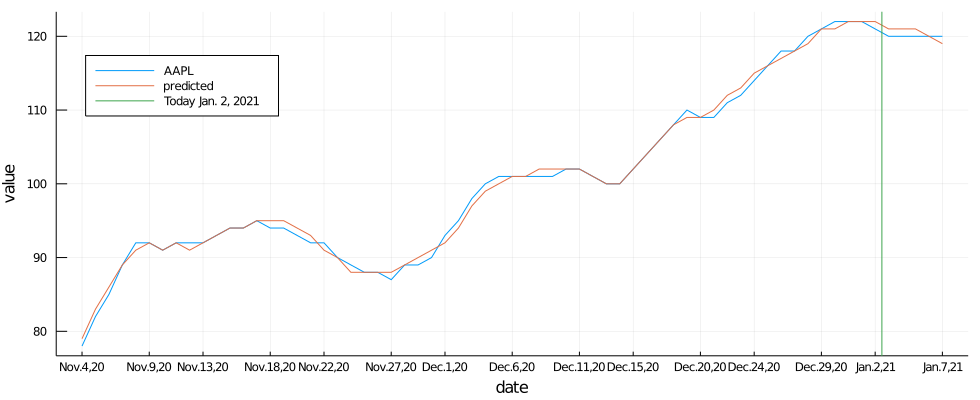

In [13]:
## Draw Plot

using Plots 

gr()
plot(            x_axis_dates,
               [ y_axis_original   y_axis_predicted ], # y-axis
    label    = [ symbol_to_predict "predicted"  "" ],
    legend   =:topleft, 
              # :right, :left, :top, :bottom, :inside, :best, :legend, :topright, :topleft, :bottomleft, :bottomright
    xlabel   = "date",
    ylabel   = "value",
    size     = (980, 400), # width, height
    layout = (1, 1), # number of graphs: vertically, horizontally
    )

## Add veritical today line

plot!([today_id], seriestype="vline", label=[ "Today "*t "" ],)

In [14]:
## Save plot graph

path_to_save = "../images/predictions_" * symbol_to_predict * ".png"
println("Saving plot image to ", path_to_save)
savefig(path_to_save)

Saving plot image to ../images/predictions_AAPL.png


In [15]:
## print prediction comparisons

println(symbol_to_predict, " ", today())

data_original = y_axis_original
data_predicted = y_axis_predicted
data_all_predicitons = data_to_predict

include("../Julia/print_predictions.jl")
print_predictions(data_to_predict,prediction_results, symbol_to_predict)

AAPL 2021-01-02
Sun, 2020-12-27	 predicted 118.0	, but actual value was 	118.0	 difference is 0.0
Mon, 2020-12-28	 predicted 119.0	, but actual value was 	120.0	 difference is -1.0
Tue, 2020-12-29	 predicted 121.0	, but actual value was 	121.0	 difference is 0.0
Wed, 2020-12-30	 predicted 121.0	, but actual value was 	122.0	 difference is -1.0
Thu, 2020-12-31	 predicted 122.0	, but actual value was 	122.0	 difference is 0.0
Fri, 2021-01-01	 predicted 122.0	, but actual value was 	122.0	 difference is 0.0
Sat, 2021-01-02	 predicted 122.0	, but actual value was 	121.0	 difference is 1.0
Sun, 2021-01-03	 predicted 121.0
Mon, 2021-01-04	 predicted 121.0
Tue, 2021-01-05	 predicted 121.0
Wed, 2021-01-06	 predicted 120.0
Thu, 2021-01-07	 predicted 119.0
